# Bible Clustering

Dataset: https://www.kaggle.com/oswinrh/bible

Clustering Bible chapters into Old/New Testament

Methods used:
- k-means
- spectral clustering
- agglomerative clustering
- gaussian mixture

Comparisons with:
- SGD classifier
- random baseline

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

## 2. Reading the data

Read the file containing the text

Give the columns better names

In [2]:
df = pd.read_csv('t_kjv.csv', usecols=['b', 'c', 'v', 't'])
df = df.rename(columns={'b':'book', 'c':'chapter', 'v':'verset', 't':'text'})
df

,book,chapter,verset,text
0,1,1,1,In the beginning God created the heaven and th...
1,1,1,2,"And the earth was without form, and void; and ..."
2,1,1,3,"And God said, Let there be light: and there wa..."
3,1,1,4,"And God saw the light, that it was good: and G..."
4,1,1,5,"And God called the light Day, and the darkness..."
...,...,...,...,...
31098,66,22,17,"And the Spirit and the bride say, Come. And le..."
31099,66,22,18,For I testify unto every man that heareth the ...
31100,66,22,19,And if any man shall take away from the words ...
31101,66,22,20,"He which testifieth these things saith, Surely..."


Add a blank space at the end of each verset

Combine the versets into their chapters

In [3]:
df['text'] = df['text'].apply(lambda t: t + ' ')
df = df.groupby(['book', 'chapter'], as_index=False)['text'].sum()
df

,book,chapter,text
0,1,1,In the beginning God created the heaven and th...
1,1,2,"Thus the heavens and the earth were finished, ..."
2,1,3,Now the serpent was more subtil than any beast...
3,1,4,"And Adam knew Eve his wife; and she conceived,..."
4,1,5,This is the book of the generations of Adam. I...
...,...,...,...
1184,66,18,And after these things I saw another angel com...
1185,66,19,And after these things I heard a great voice o...
1186,66,20,"And I saw an angel come down from heaven, havi..."
1187,66,21,And I saw a new heaven and a new earth: for th...


Read the file containing the Testament labels

Give the columns better names

In [4]:
book_names = pd.read_csv('key_english.csv', usecols=['b', 'n', 't'])
book_names = book_names.rename(columns={'b':'book', 'n':'name', 't':'testament'})
book_names

,book,name,testament
0,1,Genesis,OT
1,2,Exodus,OT
2,3,Leviticus,OT
3,4,Numbers,OT
4,5,Deuteronomy,OT
...,...,...,...
61,62,1 John,NT
62,63,2 John,NT
63,64,3 John,NT
64,65,Jude,NT


Add the Testament labels column to the main dataframe

Replace 'OT' and 'NT' labels with 0 and 1

In [5]:
df = pd.merge(df, book_names, on='book')
df['testament'] = df['testament'].replace(to_replace=['OT', 'NT'], value=[0, 1])
df

,book,chapter,text,name,testament
0,1,1,In the beginning God created the heaven and th...,Genesis,0
1,1,2,"Thus the heavens and the earth were finished, ...",Genesis,0
2,1,3,Now the serpent was more subtil than any beast...,Genesis,0
3,1,4,"And Adam knew Eve his wife; and she conceived,...",Genesis,0
4,1,5,This is the book of the generations of Adam. I...,Genesis,0
...,...,...,...,...,...
1184,66,18,And after these things I saw another angel com...,Revelation,1
1185,66,19,And after these things I heard a great voice o...,Revelation,1
1186,66,20,"And I saw an angel come down from heaven, havi...",Revelation,1
1187,66,21,And I saw a new heaven and a new earth: for th...,Revelation,1


## 3. Preprocessing the data

Use TF-IDF to convert the text into numbers

Create a Tokenizer class to be used by the TfidfVectorizer

Tokenize and lemmatize the text

Set max_df to 0.25 in order to ignore words that appear in more than 25% of the documents

Limit the number of features to 5000

In [6]:
class Tokenizer:
    def __init__(self):
        self.t = RegexpTokenizer(r'\w+')
        self.l = WordNetLemmatizer()
    def __call__(self, text):
        return [self.l.lemmatize(word) for word in self.t.tokenize(text)]

vectorizer = TfidfVectorizer(tokenizer=Tokenizer(), max_df = 0.25, max_features=5000)
X = vectorizer.fit_transform(df['text'])
y_true = df['testament']

Print the number of samples and features for each sample

In [7]:
X.shape

(1189, 5000)

Print the numbered of labeled samples

In [8]:
y_true.shape

(1189,)

## 4. Clustering

Create a function that will be used by multiple clustering methods

The function will receive chapters X with 2 features (obtained from dimensionality reduction) and Y with label values 0 and 1 (Old and New Testament)

The "args" optional parameter will be used for k-means centroids. The other methods don't have centroids

In [9]:
def cluster(X, y, method, *args):
    X_y = pd.DataFrame(dict(X1=X[0], X2=X[1], y=y))
    
    cluster_1 = X_y[X_y['y']==0]
    cluster_2 = X_y[X_y['y']==1]
    
    plt.scatter(cluster_1['X1'], cluster_1['X2'], label='Old Testament', alpha=0.5)
    plt.scatter(cluster_2['X1'], cluster_2['X2'], label='New Testament', alpha=0.5)

    if args:
        centroids = args[0]
        plt.scatter(centroids[:, 0], centroids[:, 1], label='Centroid', marker='X', color='k', s=100, alpha=0.5)
        
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(method)
    plt.legend()
    plt.show()

Create a function that will be used for calculating the accuracy score, f1 score, confusion matrix

The label assignment by clustering might be opposite (1 instead of 0 and 0 instead of 1), so we have to do a bitwise XOR and check which label assignment is the correct one

Return the accuracy and f1 scores to be later used in bar plots

In [10]:
def metrics(y_true, y_predicted_1):
    y_predicted_2 = [y^1 for y in y_predicted_1]
    
    accuracy_1 = accuracy_score(y_true, y_predicted_1) 
    accuracy_2 = accuracy_score(y_true, y_predicted_2) 
    
    if accuracy_1 > accuracy_2:
        accuracy = accuracy_1
        y_predicted = y_predicted_1
    else:
        accuracy = accuracy_2
        y_predicted = y_predicted_2
        
    f1 = f1_score(y_true, y_predicted)
    cm = confusion_matrix(y_true, y_predicted)
    print('Accuracy score:', accuracy)
    print('F1 score:', f1)
    print('Confusion matrix:\n', cm)
    return accuracy, f1

Perform dimensionality reduction from 5000 to 2 features

Choose TruncatedSVD because X is a sparse matrix

In [11]:
svd = TruncatedSVD()
X = pd.DataFrame(svd.fit_transform(X))
X.shape

(1189, 2)

Plot the ground truth labels

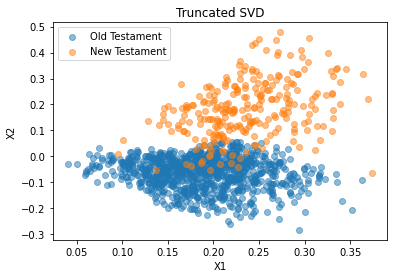

In [12]:
cluster(X, y_true, 'Truncated SVD')

Try the following methods:
- k-means
- spectral clustering
- agglomerative clustering
- gaussian mixture

Plot and print the scores

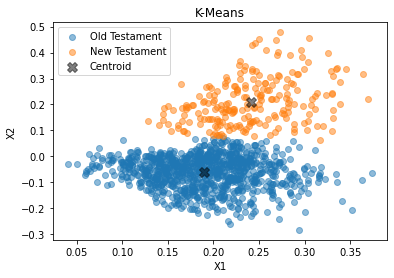

Accuracy score: 0.9671993271656855
F1 score: 0.9189189189189189
Confusion matrix:
 [[929   0]
 [ 39 221]]


In [13]:
km = KMeans(n_clusters=2)
y_predicted = km.fit_predict(X)
centroids = km.cluster_centers_
cluster(X, y_predicted, 'K-Means', centroids)
km_metrics = metrics(y_true, y_predicted)

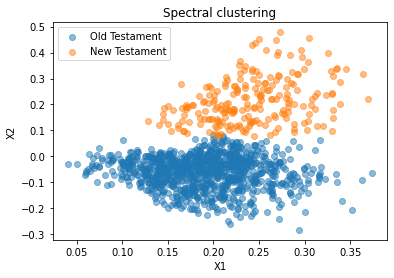

Accuracy score: 0.9646761984861227
F1 score: 0.9121338912133891
Confusion matrix:
 [[929   0]
 [ 42 218]]


In [14]:
sc = SpectralClustering(n_clusters=2)
y_predicted = sc.fit_predict(X)
cluster(X, y_predicted, 'Spectral clustering')
sc_metrics = metrics(y_true, y_predicted)

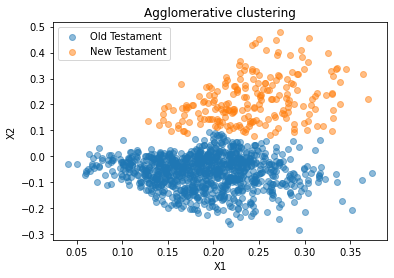

Accuracy score: 0.960470984020185
F1 score: 0.9006342494714588
Confusion matrix:
 [[929   0]
 [ 47 213]]


In [15]:
ac = AgglomerativeClustering(n_clusters=2)
y_predicted = ac.fit_predict(X)
cluster(X, y_predicted, 'Agglomerative clustering')
ac_metrics = metrics(y_true, y_predicted)

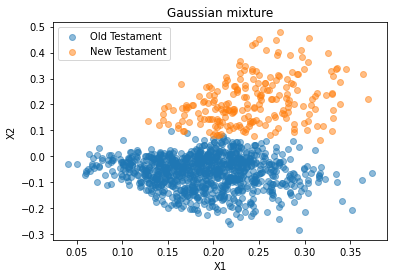

Accuracy score: 0.9646761984861227
F1 score: 0.9121338912133891
Confusion matrix:
 [[929   0]
 [ 42 218]]


In [16]:
gm = GaussianMixture(n_components=2)
y_predicted = gm.fit_predict(X)
cluster(X, y_predicted, 'Gaussian mixture')
gm_metrics = metrics(y_true, y_predicted)

## 5. Classification

Split data into 80% training and 20% testing set

Perform dimensionality reduction

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['testament'], test_size=0.2)

X_train = vectorizer.fit_transform(X_train)
X_train = svd.fit_transform(X_train)

X_test = vectorizer.fit_transform(X_test)
X_test = svd.fit_transform(X_test)

Try the SGD classifier

In [18]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
y_predicted = sgd.predict(X_test)
sgd_metrics = metrics(y_test, y_predicted)

Accuracy score: 0.8949579831932774
F1 score: 0.7826086956521738
Confusion matrix:
 [[168  19]
 [  6  45]]


## 6. Baseline prediction

Create a random chance baseline

The labels have only values 0 and 1, so we can find the probability of label 1 by calculating the mean

In [19]:
probability = np.mean(y_train)
probability

0.21976866456361724

Test the prediction

In [20]:
y_predicted = np.random.choice(2, len(y_test), p=[1-probability, probability])
r_metrics = metrics(y_test, y_predicted)

Accuracy score: 0.6764705882352942
F1 score: 0.33043478260869563
Confusion matrix:
 [[142  45]
 [ 32  19]]


## 7. Results

Plot bars for accuracy score and f1 score of each methodused

Unsupervised methods are blue colored, supervised orange, random baseline red

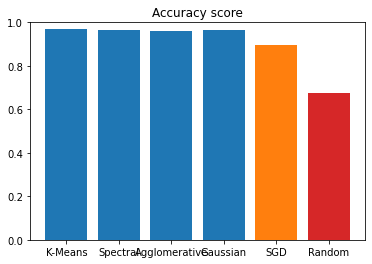

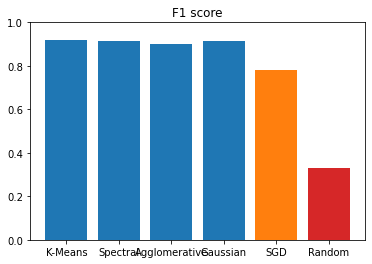

In [21]:
for i in range(0, 2):
    method = ['K-Means', 'Spectral', 'Agglomerative', 'Gaussian', 'SGD', 'Random']
    metric_score = [km_metrics[i], sc_metrics[i], ac_metrics[i], gm_metrics[i], sgd_metrics[i], r_metrics[i]]
    metric_type = ['Accuracy score', 'F1 score']
    color = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:orange', 'tab:red']
    
    plt.bar(method, metric_score, color=color)
    plt.title(metric_type[i])
    plt.ylim(0, 1)
    plt.show()

The clustering methods have similar accuracy scores (96%)

The classification method can have better scores sometimes, but it performs worse on average (84%)